In [3]:
import pandas as pd
import numpy as np

import tensorflow.compat.v1.keras.backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
tf.compat.v1.disable_v2_behavior()

from numpy.random import seed
seed(30)
import tensorflow as tf
import shap

#SHAP values
shap_values= np.load('shap_values_1500.pkl', allow_pickle=True) 
x_test_2d = pd.read_pickle(r'./shap_features_1500.pkl')

shap_values_2D = shap_values

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


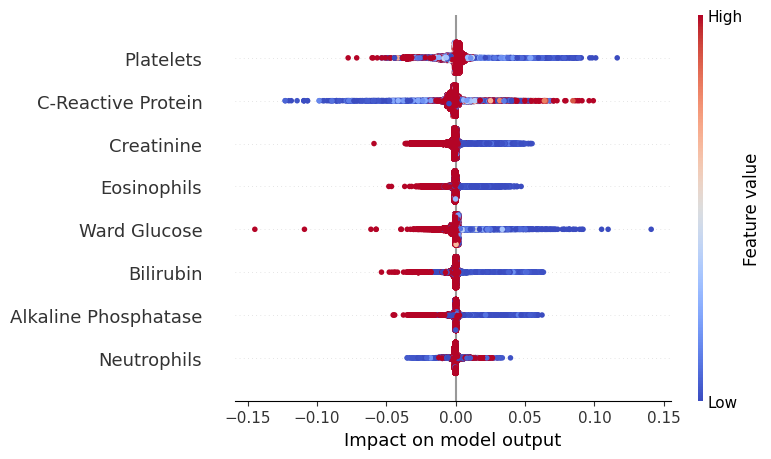

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,10))
shap.summary_plot(shap_values_2D.values, x_test_2d,max_display=8,plot_type='dot', show=False)#color=cmap
plt.xlabel('Impact on model output')
my_cmap = plt.get_cmap('coolwarm')
           
# Change the colormap of the artists
for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"):
            fcc.set_cmap(my_cmap)

In [13]:
import pandas as pd

# Define the number of repetitions for the index and features
samples = 1000
timesteps = 15

# Create a list of repeating values for the index
index_values = [i for i in range(1, samples+1) for j in range(timesteps)]

# Create a list of decreasing values for the features
feature_values = [j for i in range(samples) for j in range(-timesteps+1, 1, 1)]

data = {'sample': index_values, 'timestep': feature_values}

data_i = pd.DataFrame(data)

In [14]:
shap_values_2D[['sample','timestep']]=data_i
x_test_2d[['sample','timestep']]=data_i

In [15]:
features = ['Ward Glucose', 'Haemoglobin',
       'Mean cell volume, blood', 'White blood cell count, blood',
       'Haematocrit', 'Platelets', 'Urea level, blood', 'Creatinine', 'Sodium',
       'Potassium', 'Lymphocytes', 'Neutrophils', 'C-Reactive Protein',
       'Eosinophils', 'Alkaline Phosphatase', 'Albumin',
       'Alanine Transaminase', 'Bilirubin', 'Total Protein',
       'Fibrinogen (clauss)', 'Glucose POCT Strip Blood', 'Ferritin',
       'D-Dimer', 'Ward Lactate', 'age', 'sex', 'SARS CoV-2 RNA']



In [16]:
shap_values_2D = pd.DataFrame(shap_values_2D.set_index(['sample','timestep']).stack()).reset_index()
x_test_2d =  pd.DataFrame(x_test_2d.set_index(['sample','timestep']).stack()).reset_index()

In [17]:
shap_values_2D.columns=['sample','timestep','features','shap_values']
x_test_2d.columns=['sample','timestep','features','feature_values']
data = shap_values_2D
data['feature_values'] = x_test_2d['feature_values']

   sample  timestep                       features  shap_values   
0     1.0     -14.0                   Ward Glucose    -0.000034  \
1     1.0     -14.0                    Haemoglobin    -0.000582   
2     1.0     -14.0        Mean cell volume, blood     0.000151   
3     1.0     -14.0  White blood cell count, blood     0.000841   
4     1.0     -14.0                    Haematocrit    -0.000308   
5     1.0     -14.0                      Platelets     0.001875   
6     1.0     -14.0              Urea level, blood    -0.000437   
7     1.0     -14.0                     Creatinine    -0.000356   
8     1.0     -14.0                         Sodium     0.000940   
9     1.0     -14.0                      Potassium    -0.000123   

   feature_values  
0             0.0  
1             0.0  
2             0.0  
3             0.0  
4             0.0  
5             0.0  
6             0.0  
7             0.0  
8             0.0  
9             0.0  
 0. Computing... Alanine Transaminase
 1. 

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


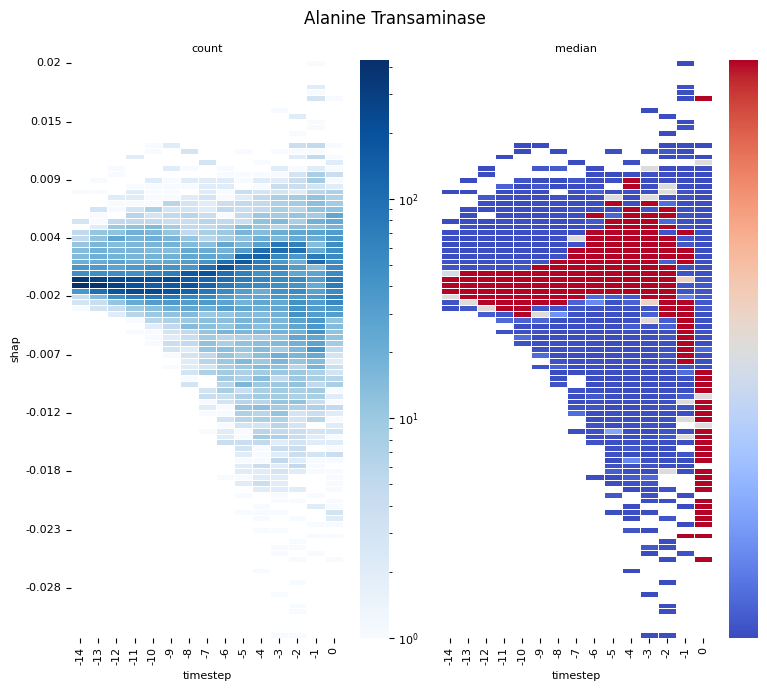

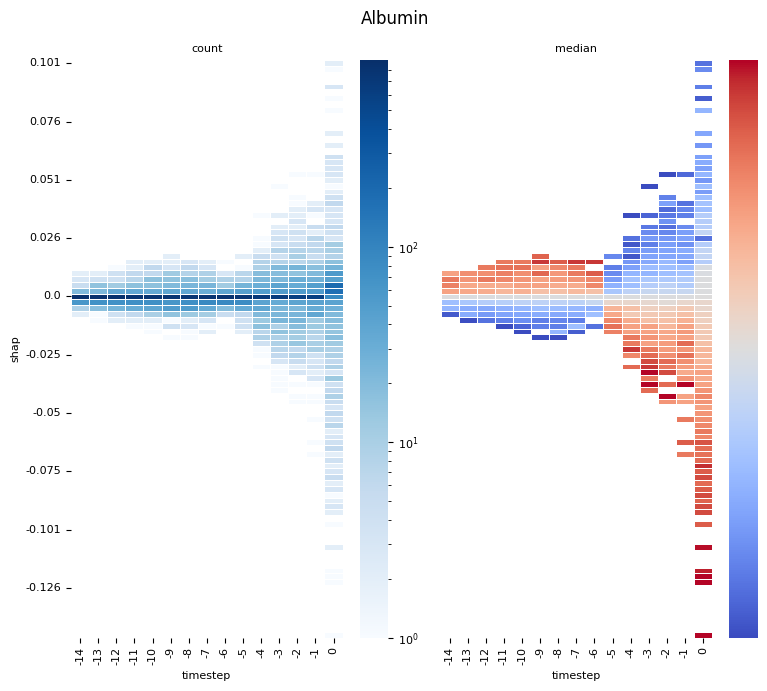

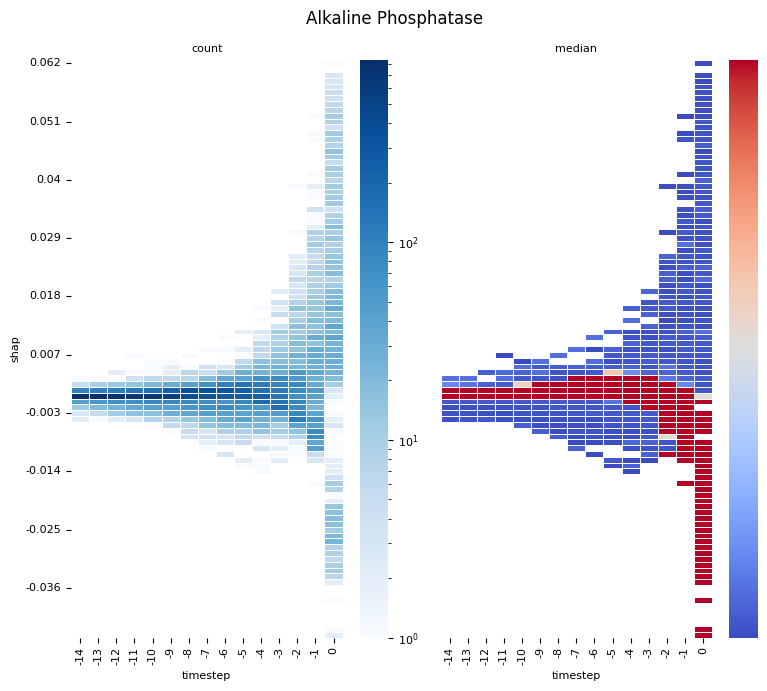

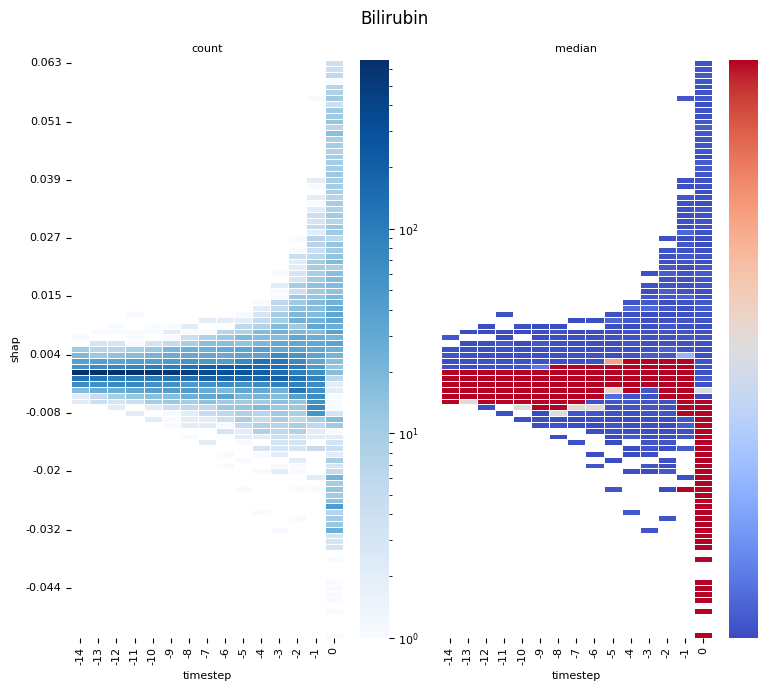

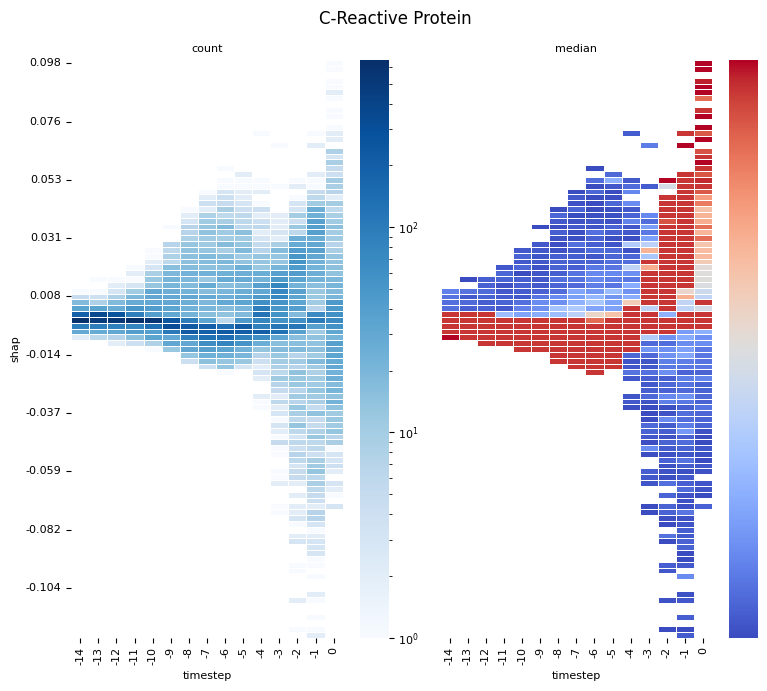

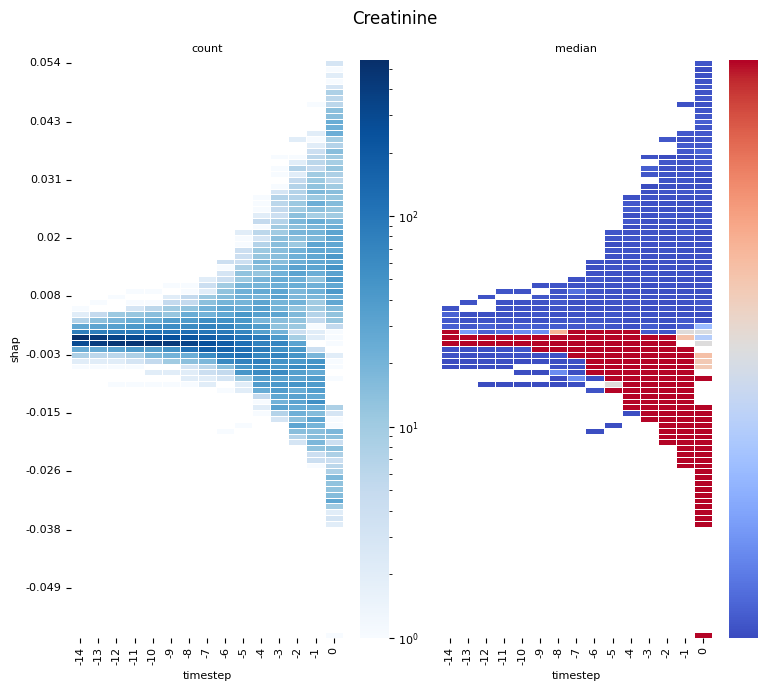

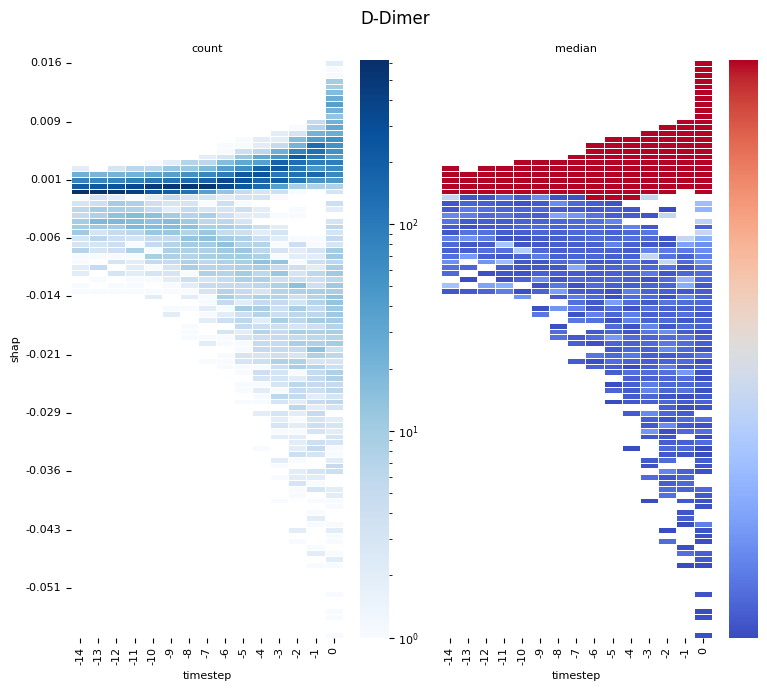

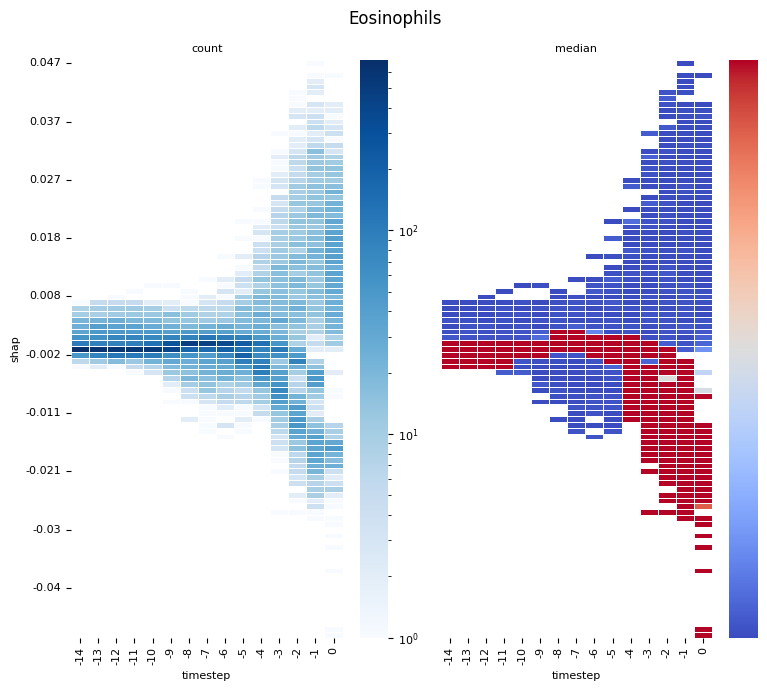

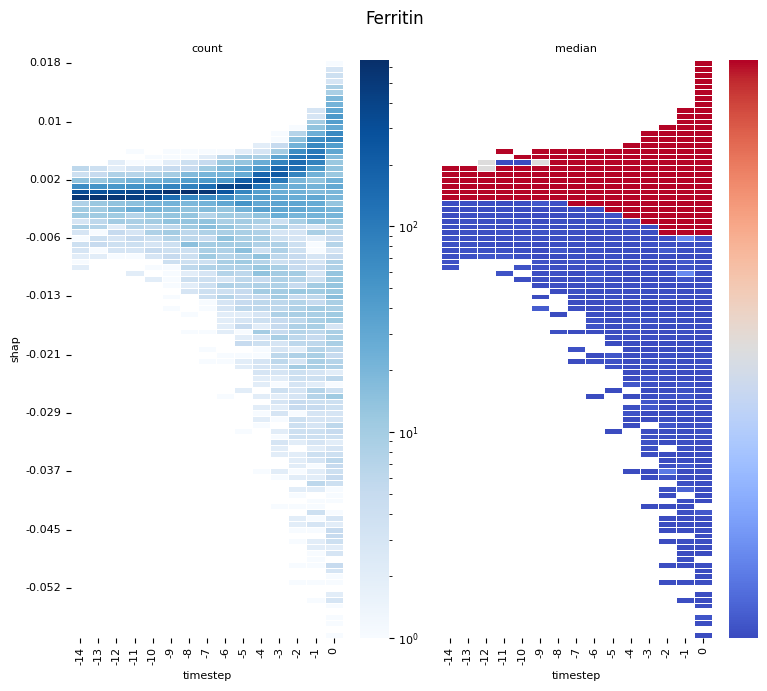

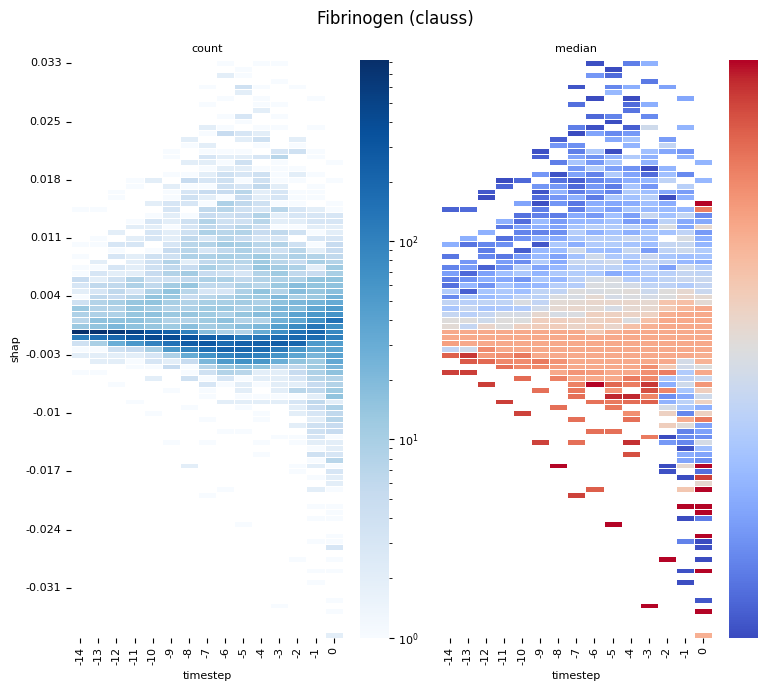

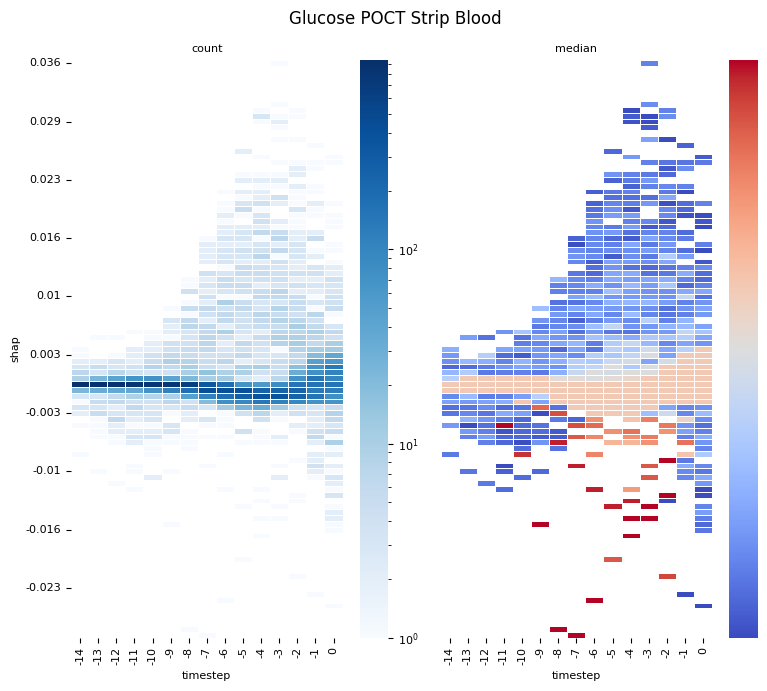

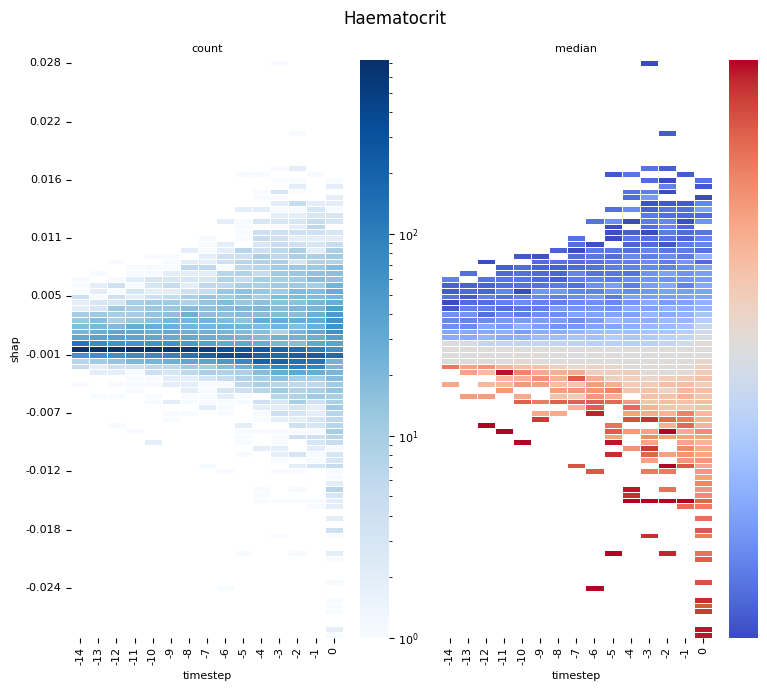

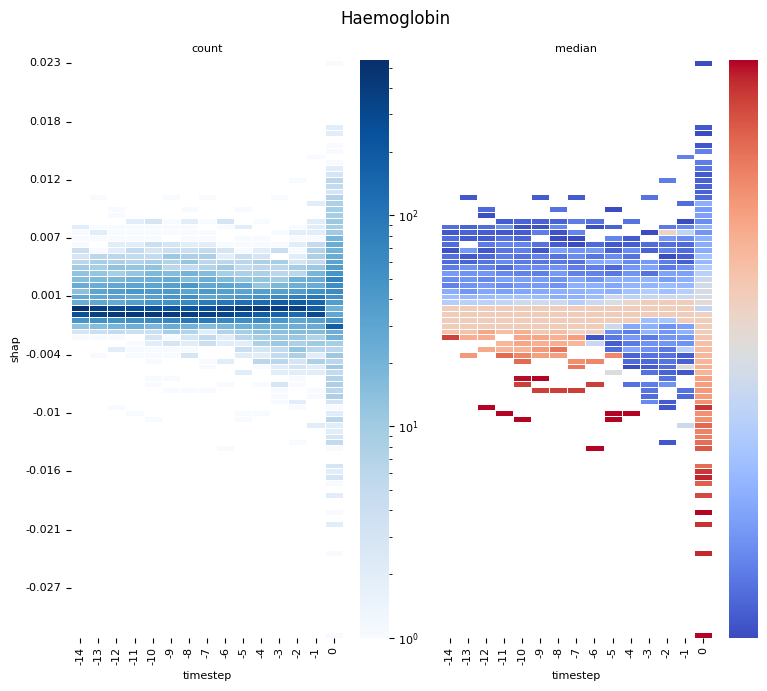

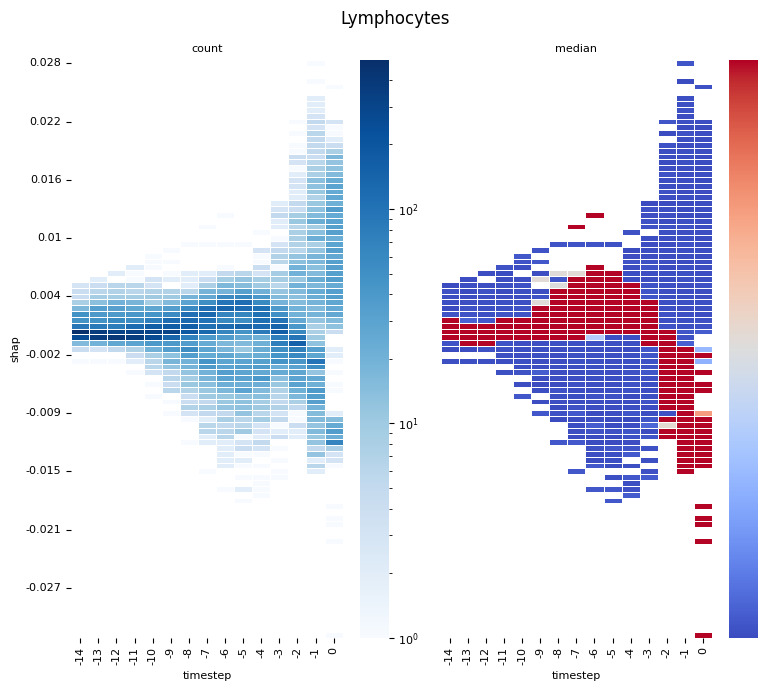

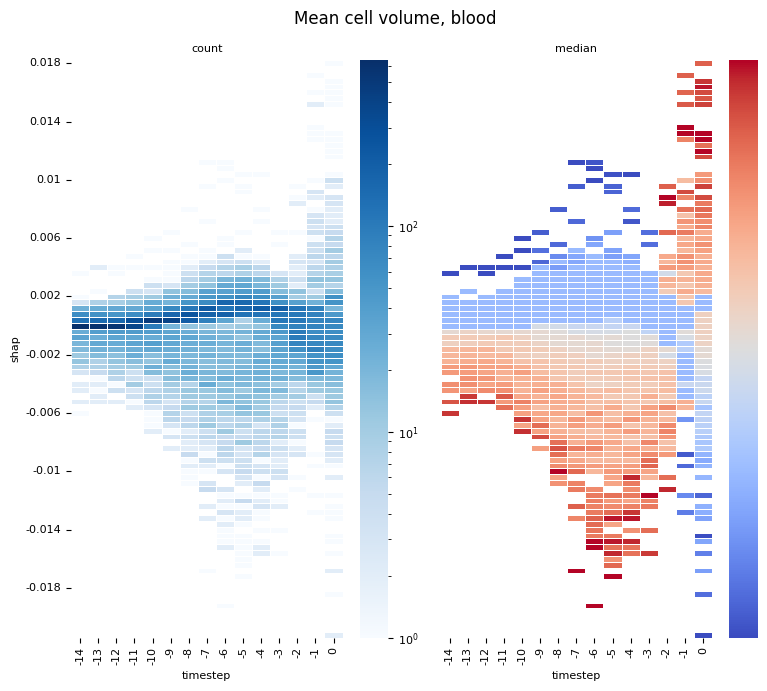

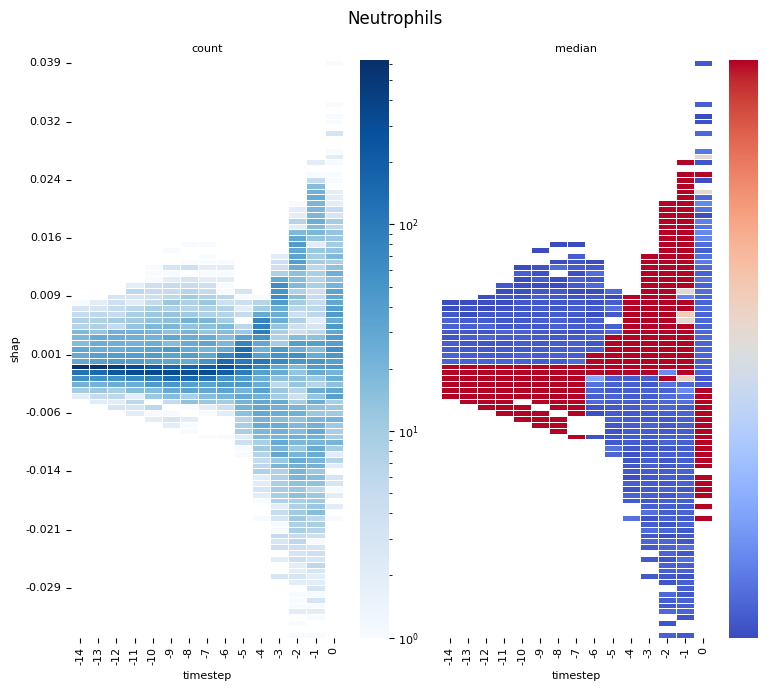

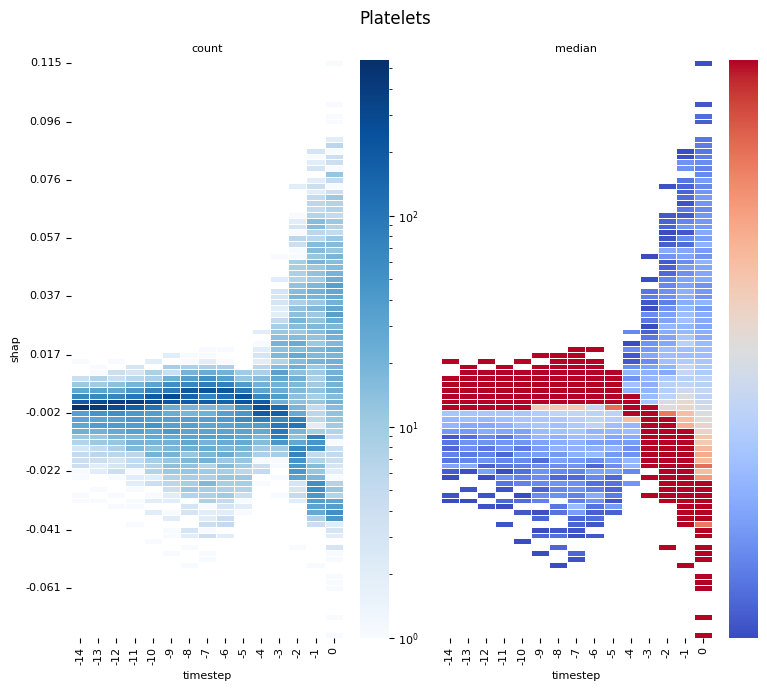

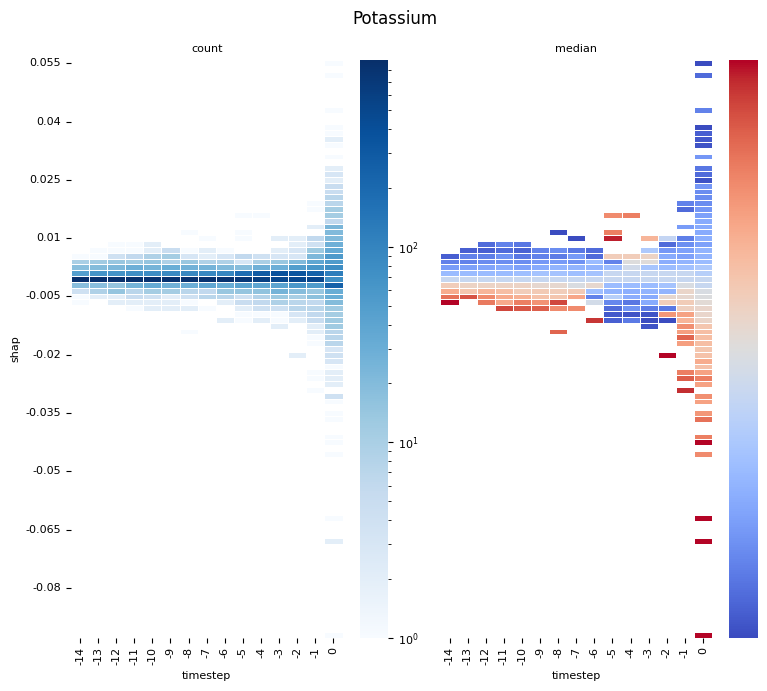

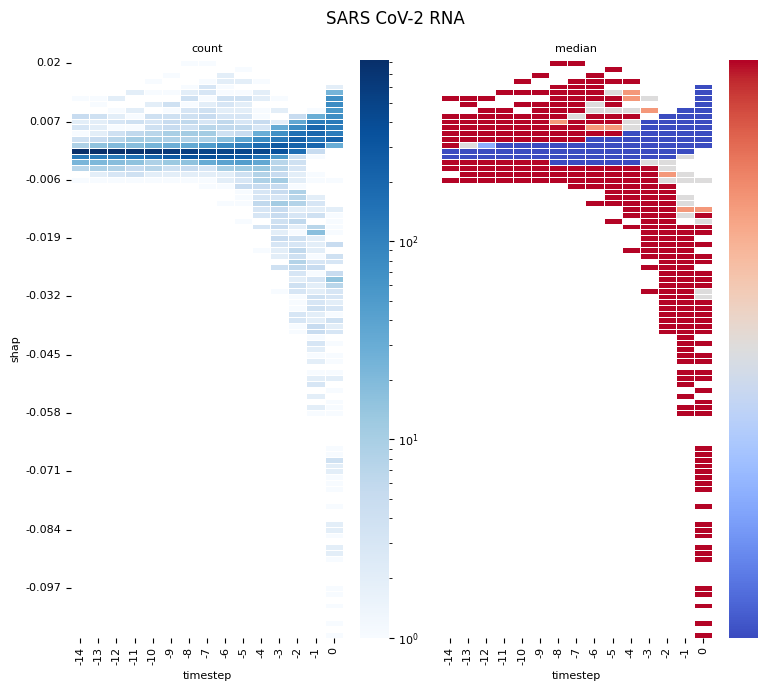

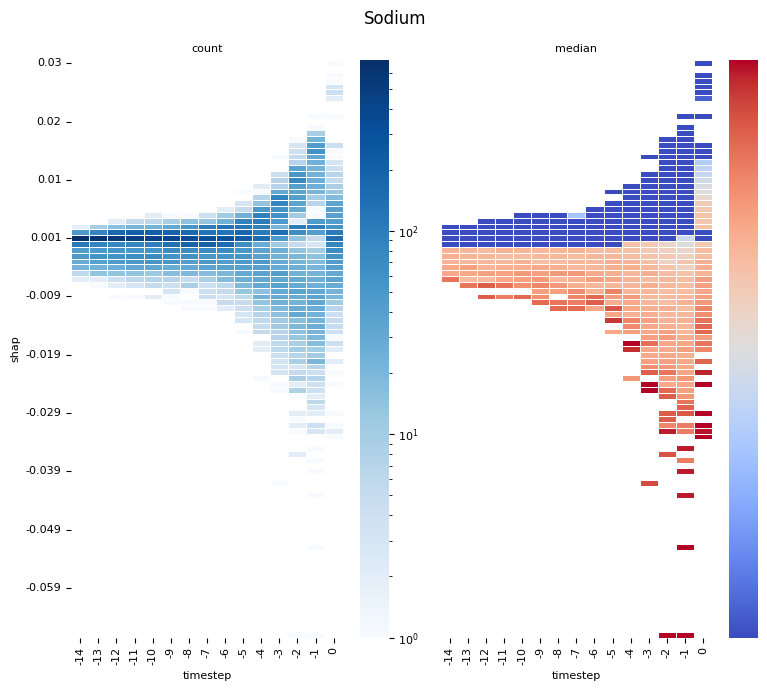

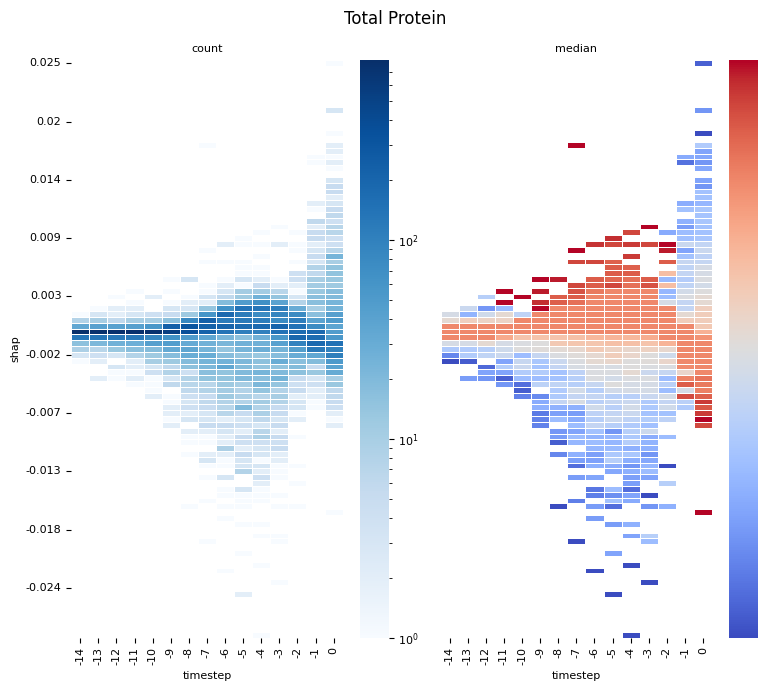

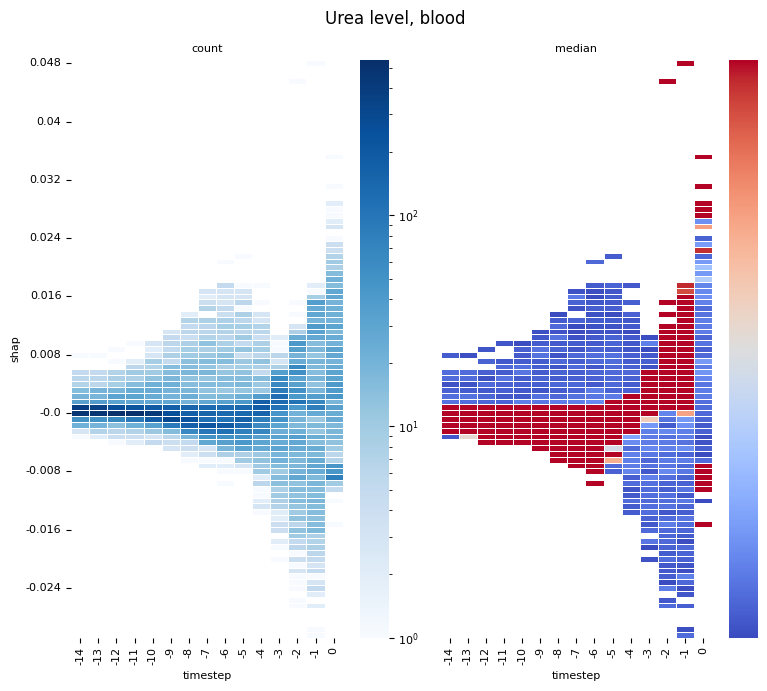

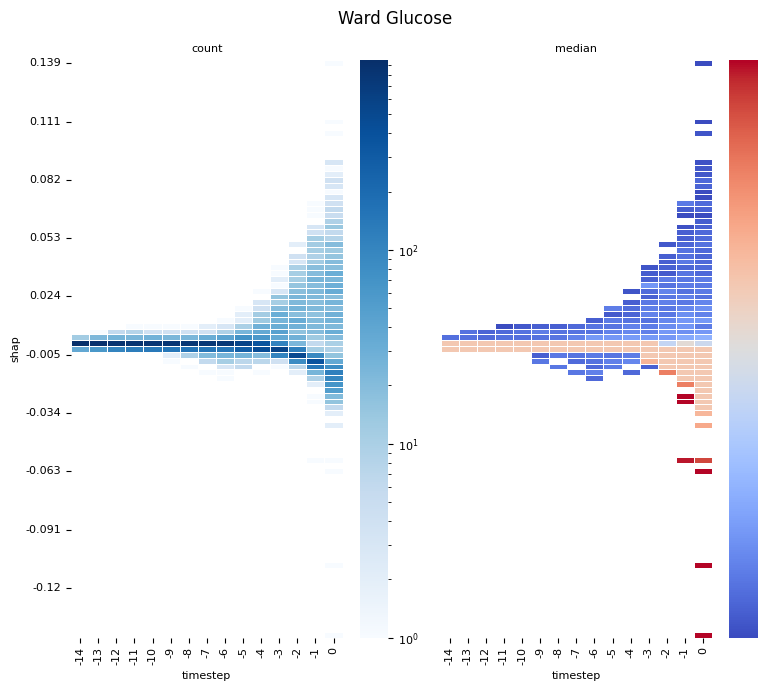

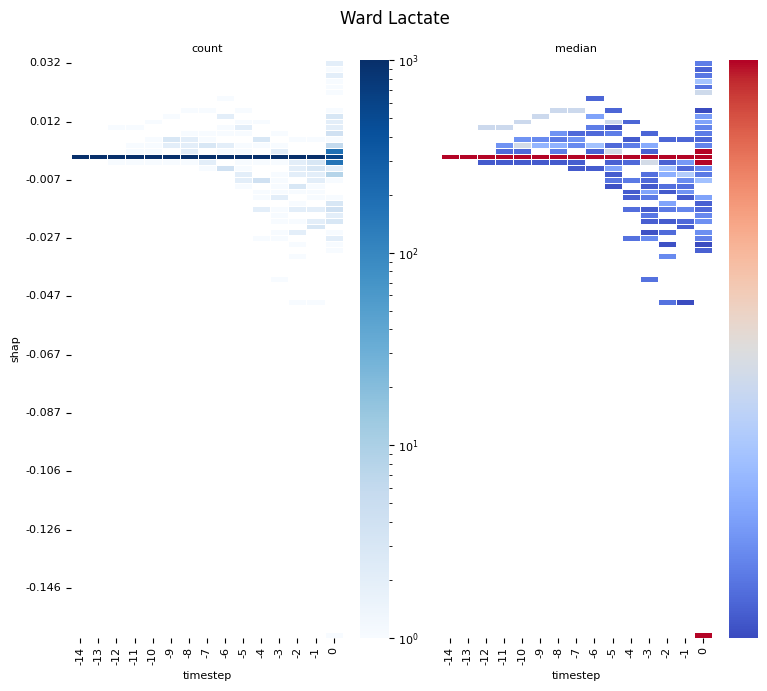

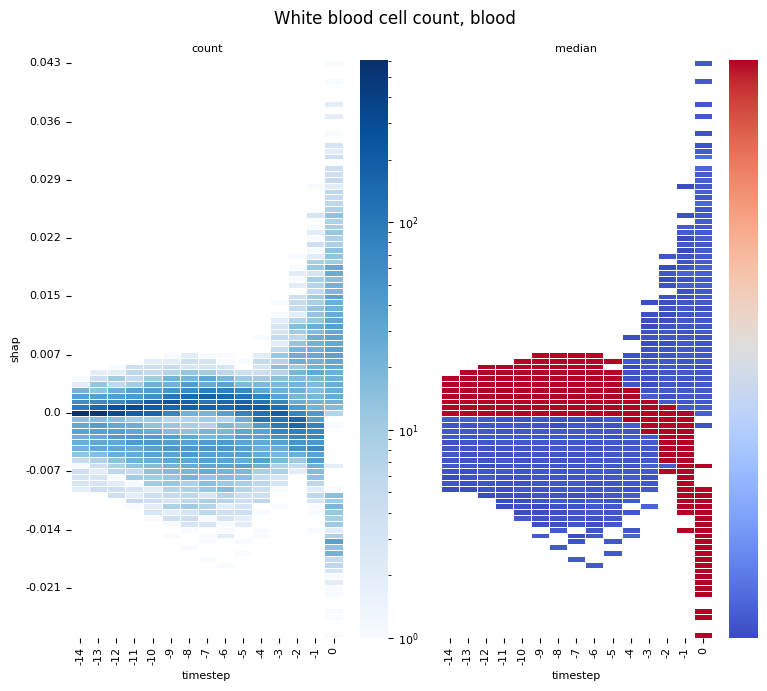

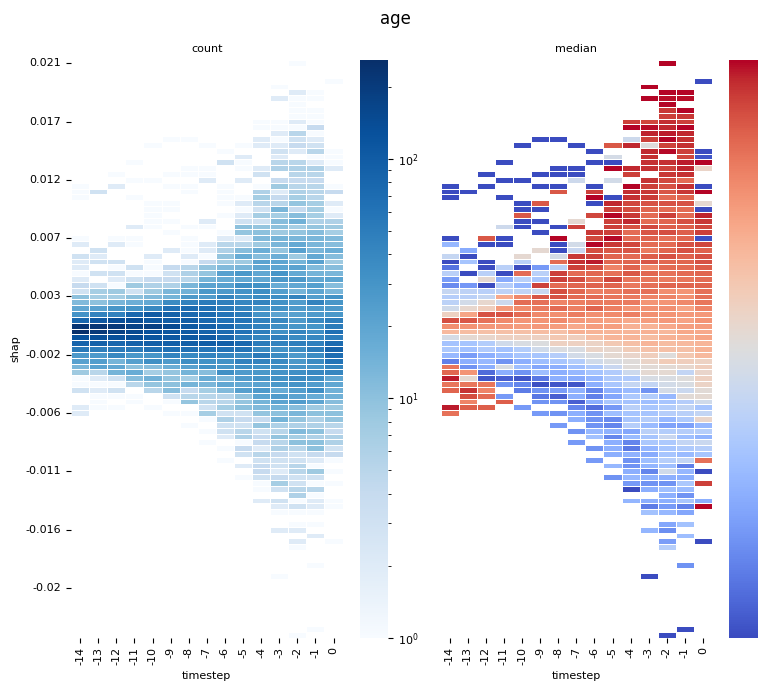

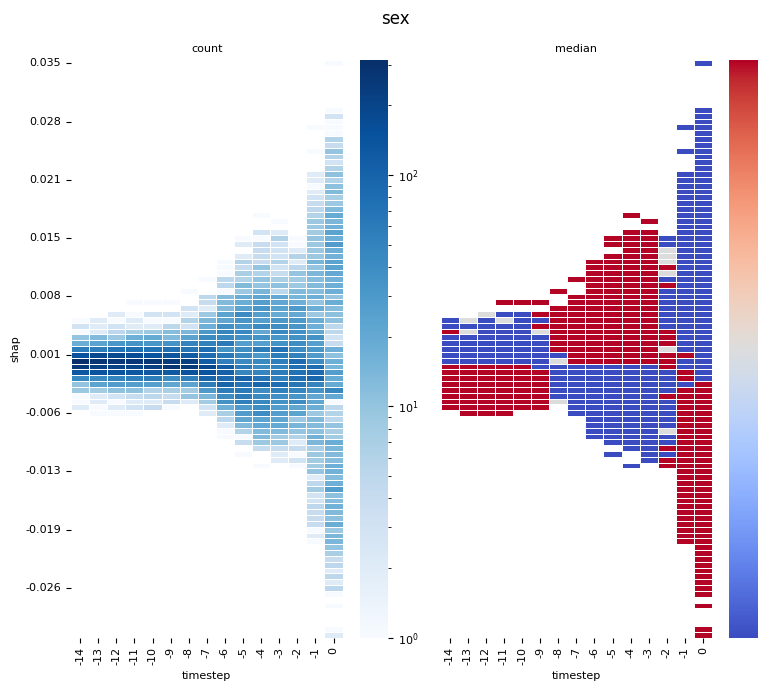

In [21]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.colors import LogNorm

#plt.style.use('ggplot') # R ggplot style

# See https://matplotlib.org/devdocs/users/explain/customizing.html

mpl.rcParams['axes.titlesize'] = 8
mpl.rcParams['axes.labelsize'] = 8
mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 8



# Show
print(data.head(10))

# Loop

for i, (name, df) in enumerate(data.groupby('features')):
  # Info
    print("%2d. Computing... %s" % (i, name))
    # Get variables
    x = df.timestep
    y = df.shap_values
    z = df.feature_values
    n = x.max()
    vmin = z.min()
    vmax = z.max()
    nbins = 100
    figsize = (8, 7)

    # Create bins
    binx = np.arange(x.min(), x.max()+2, 1) - 0.5
    biny = np.linspace(y.min(), y.max(), nbins)

    # Compute binned statistic (count)
    r1 = stats.binned_statistic_2d(x=y, y=x, values=z,
        statistic='count', bins=[biny, binx],
        expand_binnumbers=False)

    # Compute binned statistic (median)
    r2 = stats.binned_statistic_2d(x=y, y=x, values=z,
        statistic='median', bins=[biny, binx],
        expand_binnumbers=False)

    # Compute centres
    x_center = (r1.x_edge[:-1] + r1.x_edge[1:]) / 2
    y_center = (r1.y_edge[:-1] + r1.y_edge[1:]) / 2

    # Flip
    flip1 = np.flip(r1.statistic, 0)
    flip2 = np.flip(r2.statistic, 0)

    # Display
    fig, axs = plt.subplots(nrows=1, ncols=2,
        sharey=True, sharex=False, figsize=figsize)

    sns.heatmap(flip1, annot=False, linewidth=0.5,
                xticklabels=y_center.astype(int),
                yticklabels=x_center.round(3)[::-1],  # Because of flip
                cmap='Blues', ax=axs[0], norm=LogNorm(),
                cbar_kws={
                    #'label': 'value [unit]',
                    'use_gridspec': True,
                    'location': 'right'
                }
    )

    try:
        vmin=d[name]['vmin'] 
        vmax=d[name]['vmax'] 
        center=d[name]['center'] 
    except:
        vmin, vmax, center = None, None, None


    sns.heatmap(flip2, annot=False, linewidth=0.5,
                xticklabels=y_center.astype(int),
                yticklabels=x_center.round(3)[::-1],  # Because of flip
                cmap='coolwarm', ax=axs[1], zorder=1,
                vmin=vmin, 
                vmax=vmax, 
                center=center, 
                robust=True,
                cbar_kws={
                    #'label': 'value [unit]',
                    'use_gridspec': True,
                    'location': 'right',
                    'ticks':[]                                            
                }
    )


    # Configure ax0
    axs[0].set_title('count')
    axs[0].set_xlabel('timestep')
    axs[0].set_ylabel('shap')
    axs[0].locator_params(axis='y', nbins=10)

    # Configure ax1
    axs[1].set_title('median')
    axs[1].set_xlabel('timestep')
    axs[1].locator_params(axis='y', nbins=10)
    axs[1].tick_params(axis=u'y', which=u'both', length=0)

    # Generic

    plt.suptitle(name)
    plt.tight_layout()

    # Show only first N

    if int(i) > 27:
        break

# Show
plt.show()